# Clasificación Multiclase de Imágenes con Deep Learning  
## Natalie Portman vs Scarlett Johansson

**Asignatura:** Inteligencia Artificial  
**Tipo:** Clasificación de Imágenes  
**Framework:** TensorFlow / Keras  

Este proyecto realiza un análisis exploratorio, preprocesamiento y preparación
de un dataset de rostros de celebridades, enfocándose únicamente en dos clases:
**Natalie Portman** y **Scarlett Johansson**.  

No se utiliza la librería sklearn, cumpliendo con los requisitos de la asignación.


In [1]:
!pip install kaggle


In [3]:
!pip -q install kaggle

# mover kaggle.json a la ruta correcta (si ya lo subiste, esto lo deja listo)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# descargar y descomprimir dataset
!kaggle datasets download -d vishesh1412/celebrity-face-image-dataset -p /content --force
!unzip -q /content/celebrity-face-image-dataset.zip -d /content/dataset

!ls /content/dataset


Dataset URL: https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset
License(s): CC0-1.0
  0% 0.00/52.9M [00:00<?, ?B/s]
100% 52.9M/52.9M [00:00<00:00, 1.41GB/s]
'Celebrity Faces Dataset'


## Selección de clases
Se crea un dataset reducido con **solo dos carpetas**:
- Natalie Portman
- Scarlett Johansson


In [4]:
import os, shutil

BASE = "/content/dataset/Celebrity Faces Dataset"
TARGET = "/content/two_classes"

classes = ["Natalie Portman", "Scarlett Johansson"]

# crear carpeta destino limpia
if os.path.exists(TARGET):
    shutil.rmtree(TARGET)
os.makedirs(TARGET, exist_ok=True)

for c in classes:
    src = os.path.join(BASE, c)
    dst = os.path.join(TARGET, c)
    shutil.copytree(src, dst)

for c in classes:
    print(c, "->", len(os.listdir(os.path.join(TARGET, c))))


Natalie Portman -> 100
Scarlett Johansson -> 200


## Exploración general del dataset (2 clases)
Se analiza:
- Número total de imágenes y distribución por clase
- Formatos (JPG/PNG/etc.)
- Resoluciones (ancho x alto)
- Imágenes corruptas o vacías
- Balance de clases
- Variedad visual: iluminación, fondo, orientación, ruido


In [5]:
import pandas as pd
from PIL import Image

info = []
corrupt = []

for label in classes:
    folder = os.path.join(TARGET, label)
    for fn in os.listdir(folder):
        path = os.path.join(folder, fn)
        try:
            with Image.open(path) as img:
                info.append({
                    "class": label,
                    "file": fn,
                    "path": path,
                    "format": img.format,
                    "mode": img.mode,
                    "width": img.size[0],
                    "height": img.size[1]
                })
        except:
            corrupt.append(path)

df = pd.DataFrame(info)

total_imgs = len(df)
dist = df["class"].value_counts()

total_imgs, dist


(300,
 class
 Scarlett Johansson    200
 Natalie Portman       100
 Name: count, dtype: int64)

In [6]:
print("Total imágenes (válidas):", len(df))
print("Corruptas:", len(corrupt))

print("\nFormatos:")
print(df["format"].value_counts())

print("\nResolución (describe):")
print(df[["width","height"]].describe())


Total imágenes (válidas): 300
Corruptas: 0

Formatos:
format
JPEG    300
Name: count, dtype: int64

Resolución (describe):
            width      height
count  300.000000  300.000000
mean   452.020000  510.056667
std     80.250025  106.763766
min    160.000000  135.000000
25%    474.000000  474.000000
50%    474.000000  554.000000
75%    474.000000  585.000000
max    474.000000  592.000000


## Variedad de condiciones (muestras)
Se visualizan imágenes para evaluar iluminación, fondos, orientación y ruido.


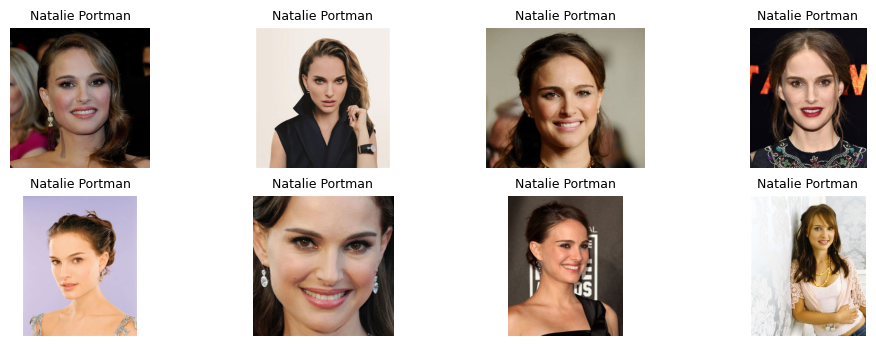

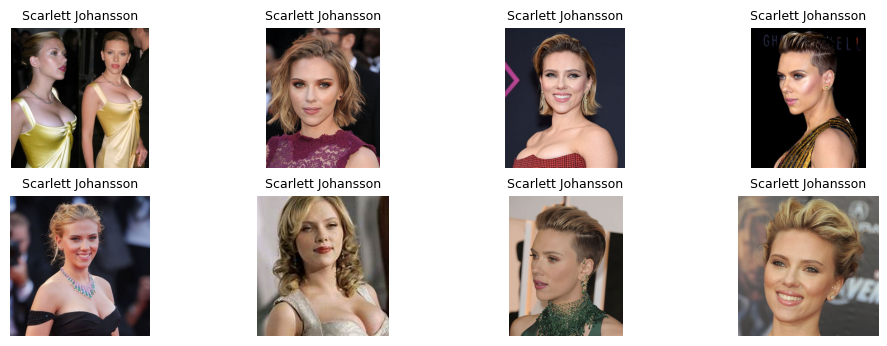

In [7]:
import matplotlib.pyplot as plt
import random

def show_samples(label, n=8):
    folder = os.path.join(TARGET, label)
    files = random.sample(os.listdir(folder), min(n, len(os.listdir(folder))))
    plt.figure(figsize=(12,4))
    for i, fn in enumerate(files, 1):
        img = Image.open(os.path.join(folder, fn))
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label, fontsize=9)
    plt.show()

show_samples("Natalie Portman", 8)
show_samples("Scarlett Johansson", 8)


## Análisis estadístico (RGB)
Se calcula:
- Media y desviación estándar por canal RGB
- Rango de valores para verificar si está en 0–255


In [8]:
import numpy as np

# muestreamos imágenes (para no cargar TODO si es grande)
sample_df = df.sample(min(400, len(df)), random_state=42)

pixels = []
for p in sample_df["path"].tolist():
    img = Image.open(p).convert("RGB").resize((224,224))
    arr = np.array(img, dtype=np.float32)  # 0-255
    pixels.append(arr)

pixels = np.stack(pixels, axis=0)  # (N,224,224,3)

mean_rgb = pixels.mean(axis=(0,1,2))
std_rgb  = pixels.std(axis=(0,1,2))
min_val  = pixels.min()
max_val  = pixels.max()

mean_rgb, std_rgb, (min_val, max_val)


(array([140.84592, 115.39977, 105.86031], dtype=float32),
 array([78.6136  , 72.45522 , 70.979294], dtype=float32),
 (np.float32(0.0), np.float32(255.0)))

## Detección de valores atípicos (outliers)
Se detectan:
- Imágenes extremadamente oscuras o brillantes (por brillo promedio)
- Imágenes potencialmente desenfocadas (varianza del Laplaciano aproximada)


In [9]:
def brightness_score(path):
    img = Image.open(path).convert("L").resize((224,224))
    arr = np.array(img, dtype=np.float32)
    return arr.mean()

df["brightness"] = df["path"].apply(brightness_score)

# extremos
dark = df.nsmallest(8, "brightness")
bright = df.nlargest(8, "brightness")

dark[["class","file","brightness"]].head(), bright[["class","file","brightness"]].head()


(                  class              file  brightness
 190  Scarlett Johansson  055_f6e1bf43.jpg   54.800999
 246  Scarlett Johansson  157_8843fa75.jpg   54.800999
 3       Natalie Portman  013_46b35530.jpg   55.381638
 119  Scarlett Johansson  088_116c6971.jpg   56.647041
 242  Scarlett Johansson  196_08de561a.jpg   56.647041,
                   class              file  brightness
 83      Natalie Portman  042_8168b9f8.jpg  210.296982
 236  Scarlett Johansson  153_e68fb09b.jpg  205.526703
 254  Scarlett Johansson  051_f852bd6d.jpg  205.526703
 43      Natalie Portman  083_7fc7beca.jpg  194.605148
 105  Scarlett Johansson  178_db9db324.jpg  193.584229)

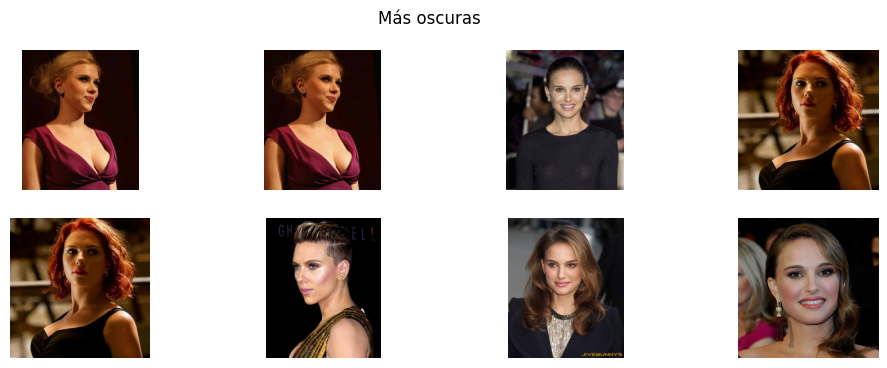

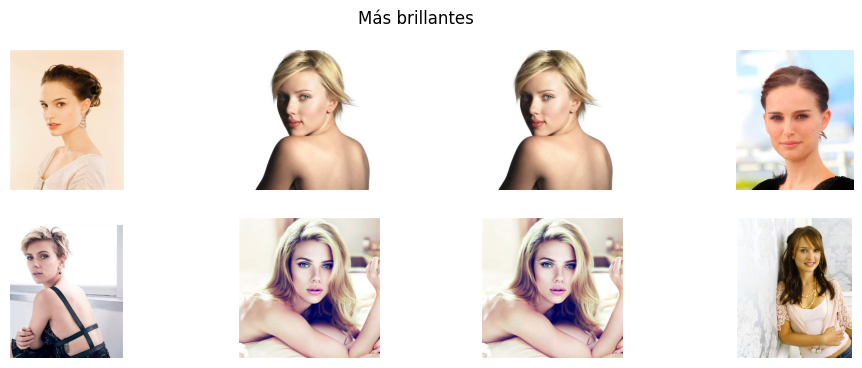

In [10]:
def show_paths(paths, title):
    plt.figure(figsize=(12,4))
    for i, p in enumerate(paths, 1):
        img = Image.open(p)
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_paths(dark["path"].tolist()[:8], "Más oscuras")
show_paths(bright["path"].tolist()[:8], "Más brillantes")


In [11]:
# Laplaciano aproximado con convolución en TF (sin sklearn)
import tensorflow as tf

kernel = tf.constant([[0., 1., 0.],
                      [1.,-4., 1.],
                      [0., 1., 0.]], dtype=tf.float32)
kernel = kernel[:, :, tf.newaxis, tf.newaxis]  # (3,3,1,1)

def blur_score(path):
    img = Image.open(path).convert("L").resize((224,224))
    x = tf.convert_to_tensor(np.array(img, dtype=np.float32)[None, ..., None])  # (1,224,224,1)
    lap = tf.nn.conv2d(x, kernel, strides=1, padding="SAME")
    return float(tf.math.reduce_variance(lap).numpy())

df["blur_score"] = df["path"].apply(blur_score)

# score bajo = potencialmente más borrosa
blurry = df.nsmallest(8, "blur_score")
blurry[["class","file","blur_score"]]


,class,file,blur_score
106,Scarlett Johansson,136_2b8c824e.jpg,310.966064
117,Scarlett Johansson,060_003a8f0c.jpg,314.316101
140,Scarlett Johansson,162_e3501030.jpg,314.316101
27,Natalie Portman,008_8fc20495.jpg,343.714478
3,Natalie Portman,013_46b35530.jpg,348.467194
190,Scarlett Johansson,055_f6e1bf43.jpg,383.067291
246,Scarlett Johansson,157_8843fa75.jpg,383.067291
6,Natalie Portman,072_7dbad240.jpg,405.347961


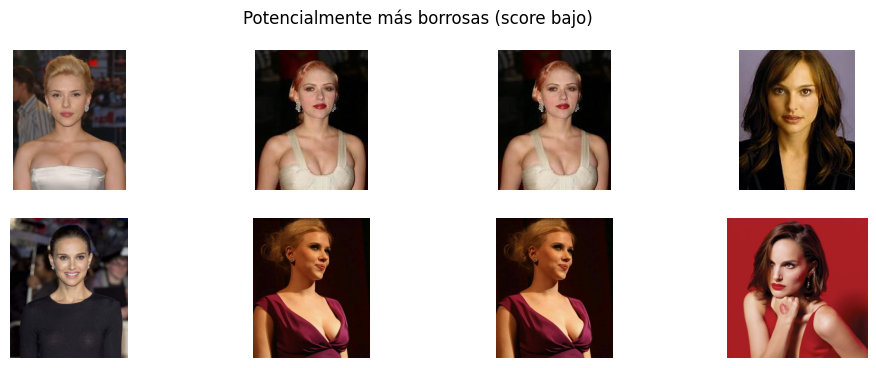

In [12]:
show_paths(blurry["path"].tolist()[:8], "Potencialmente más borrosas (score bajo)")


## Limpieza y Control de Calidad
Se realiza:
- Eliminación de corruptas / no abribles
- Detección de imágenes vacías (tamaño 0 o lectura inválida)
- Detección de duplicados por hash (MD5)


In [13]:
import hashlib

def md5_file(path, chunk=8192):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

hash_map = {}
duplicates = []

for label in classes:
    folder = os.path.join(TARGET, label)
    for fn in os.listdir(folder):
        path = os.path.join(folder, fn)

        # corruptas (si estaban en lista)
        if path in corrupt:
            continue

        # hash para duplicados
        try:
            hx = md5_file(path)
            if hx in hash_map:
                duplicates.append((path, hash_map[hx]))
            else:
                hash_map[hx] = path
        except:
            corrupt.append(path)

print("Corruptas detectadas:", len(set(corrupt)))
print("Duplicados detectados:", len(duplicates))


Corruptas detectadas: 0
Duplicados detectados: 88


In [14]:
# BORRAR duplicados (opcional, si quieres limpieza estricta)
for dup, original in duplicates:
    if os.path.exists(dup):
        os.remove(dup)

# BORRAR corruptas (opcional)
for p in set(corrupt):
    if os.path.exists(p):
        os.remove(p)

print("Limpieza aplicada.")


Limpieza aplicada.


## Preprocesamiento + Aumento de datos
- Redimensionamiento: 224x224
- Escalado a [0,1]
- Data augmentation para evitar sobreajuste


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.10,
    horizontal_flip=True,
)

val_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_aug.flow_from_directory(
    TARGET,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = val_aug.flow_from_directory(
    TARGET,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

train_gen.class_indices


Found 170 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


{'Natalie Portman': 0, 'Scarlett Johansson': 1}

## Modelo Deep Learning (CNN)
Se entrena un modelo simple para clasificar entre las dos clases.


In [16]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.5159 - loss: 1.1778 - val_accuracy: 0.6190 - val_loss: 0.6720
Epoch 2/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.5223 - loss: 0.6873 - val_accuracy: 0.5238 - val_loss: 0.6864
Epoch 3/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5197 - loss: 0.6832 - val_accuracy: 0.6190 - val_loss: 0.6732
Epoch 4/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6132 - loss: 0.6773 - val_accuracy: 0.5476 - val_loss: 0.6847
Epoch 5/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5832 - loss: 0.6670 - val_accuracy: 0.7143 - val_loss: 0.7011
Epoch 6/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5978 - loss: 0.6686 - val_accuracy: 0.6667 - val_loss: 0.7224
Epoch 7/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6317 - loss: 0.6414 - val_accuracy: 0.6429 - val_loss: 0.6563
Epoch 8/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6947 - loss: 0.6079 - val_accuracy: 0.6667 - val_loss: 0.6200


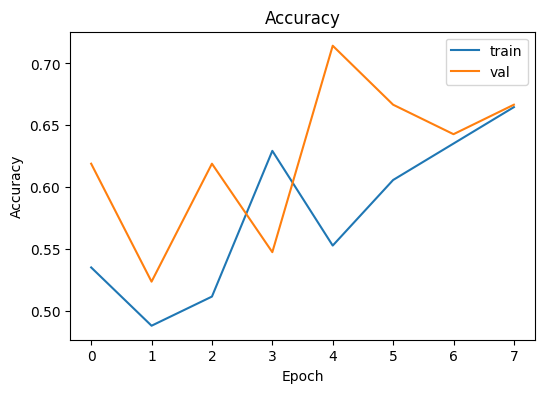

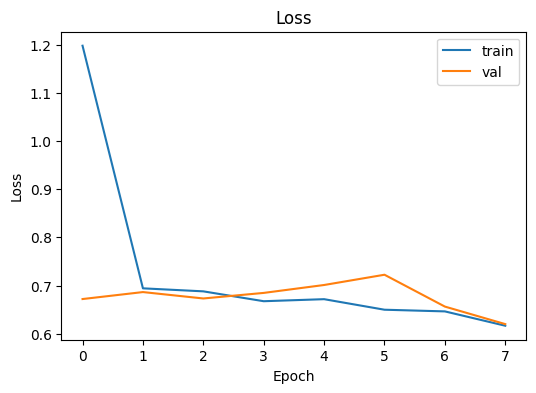

In [17]:
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train","val"])
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","val"])
plt.show()


In [18]:
model.save("/content/celebrity_2classes_model.keras")
